<h1>Evaluation of the SLI Network</h1>
<p>This repository includes a script for evaluating 15 different classification methods with node-based and edge-based sample. This notebook shows how to visualize the results. The script creates a directory called
    <tt>experiments</tt> with the results. This notebook requires the user to enter the location of the directory.</p>

In [1]:
import pandas as pd
import os
from glob import glob
import json
from barplots import barplots 

<h2>Setup (important_)</h2>
<p>This notebook excepts the user to soft link the directory of results files from the GRAPE analsys to the current working
directory. This can be done with the following command</p>
<tt>ln -s /home/../../experiments/EdgePrediction/SLDB-HomoSapiens/</tt>
<p> Once this is done the following ingest code should work. The directory <tt>SLDB-HomoSapiens</tt> contains the subdirectories
<tt>holdout_0</tt> up to <tt>holdout_9</tt> that contain individual runs. The glob command gets all files in these ten subdirectories with the suffix csv.gz.</p>

In [22]:
experiments_dir = "SLDB-HomoSapiens/"
if not os.path.exists(experiments_dir):
    raise Exception(f"Could not find directory {experiments_dir}")

In [23]:
all_experiments = f"SLDB-HomoSapiens" + "/holdout_*/*.csv.gz"
print(all_experiments)

SLDB-HomoSapiens/holdout_*/*.csv.gz


In [24]:
df = pd.concat([
    pd.read_csv(
        path,
        index_col=0
    )
    for path in glob(all_experiments)
]).reset_index(drop=True)
df.head()

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,validation_sample_only_edges_with_heterogeneous_node_types,negative_predictive_value,negative_likelyhood_ratio,false_omission_rate,f1_score,prevalence,...,"('features_parameters', 'max_neighbours')","('features_parameters', 'central_nodes_embedding_path')","('features_parameters', 'contextual_nodes_embedding_path')","('features_parameters', 'normalize_by_degree')","('features_parameters', 'stochastic_downsample_by_degree')","('features_parameters', 'normalize_learning_rate_by_degree')","('features_parameters', 'alpha')","('features_parameters', 'metric')","('features_parameters', 'root_node_name')","('features_parameters', 'contextual_node_embedding_path')"
0,train,0.007185,1.0,False,False,0.644231,0.552239,0.355769,0.643526,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test,0.007185,1.0,False,False,0.602356,0.660147,0.397644,0.590988,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train,0.007185,1.0,False,False,0.804281,0.243346,0.195719,0.819209,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,test,0.007185,1.0,False,False,0.763425,0.309886,0.236575,0.783217,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,train,0.007185,1.0,False,False,0.830461,0.204150,0.169539,0.876304,0.5,...,100.0,None,None,False,False,False,NaN,NaN,NaN,NaN


In [25]:
df = df[df.evaluation_mode == "test"]

df["train_size"] = [
    float(json.loads(holdouts_kwargs)["train_size"])
    for holdouts_kwargs in df.holdouts_kwargs
]

df["features_names"] = [
    json.loads(edge_feature.replace("'", "\""))[0] if pd.notna(edge_feature) else feature_name
    for feature_name, edge_feature in zip(
        df.features_names,
        df["('model_parameters', 'edge_features')"]
    )
]

df["use_scale_free_distribution"] = [
    "Unbiased"
    if use_scale_free_distribution
    else "Biased"
    for use_scale_free_distribution in df.use_scale_free_distribution
]

df = df[
    [
        pd.isna(a) or a == b
        for a, b in zip(
            df["('features_parameters', 'use_scale_free_distribution')"],
            df["('model_parameters', 'use_scale_free_distribution')"],
        )
    ]
]

df["features_names"] = [
    "{feature} {training}".format(
        training=("Scale-free train"
        if b
        else "Uniform train"),
        feature=feature
    )
    for a, b, feature in zip(
        df["('features_parameters', 'use_scale_free_distribution')"],
        df["('model_parameters', 'use_scale_free_distribution')"],
        df["features_names"]
    )
]

# This column is an integer but is being represented as a float
df[['validation_unbalance_rate']] = df[['validation_unbalance_rate']].astype(int)

In [ ]:
df.to_csv("all_results.tsv", sep='\t')

<h2>Extract relevant colums</h2>
<p>For clarity, we extract the columns we will use for analysis into a new dataframe.
QUESTION -- it seems as if the columns with Tuples all result in NA values. Do we need to worry?</p>

In [26]:
df2 = df[(df['validation_unbalance_rate']==1) & (df['train_size']==0.75)]

my_columns = ["features_names",
    "use_scale_free_distribution",
    "task_name"]

result = df2.groupby(my_columns, 
                     as_index=False).agg(
                      {'balanced_accuracy':['mean','std'],
                       'f1_score':['mean','std'],
                      'auprc':['mean','std'],
                      'auroc':['mean','std']})


In [ ]:
result.to_csv('result_summary_all.tsv', sep='\t')

In [41]:
unique_methods = df2["features_names"].unique()
unique_methods = sorted(unique_methods)
N = 2+ len(unique_methods)/2
for i in range(len(unique_methods)):
    print(f"{i+1}. {unique_methods[i]}") 

1. AdamicAdar Scale-free train
2. AdamicAdar Uniform train
3. DeepWalk CBOW Scale-free train
4. DeepWalk CBOW Uniform train
5. DeepWalk GloVe Scale-free train
6. DeepWalk GloVe Uniform train
7. DeepWalk SkipGram Scale-free train
8. DeepWalk SkipGram Uniform train
9. Degree Scale-free train
10. Degree Uniform train
11. First-order LINE Scale-free train
12. First-order LINE Uniform train
13. HOPE Scale-free train
14. HOPE Uniform train
15. JaccardCoefficient Scale-free train
16. JaccardCoefficient Uniform train
17. PreferentialAttachment Scale-free train
18. PreferentialAttachment Uniform train
19. ResourceAllocationIndex Scale-free train
20. ResourceAllocationIndex Uniform train
21. Second-order LINE Scale-free train
22. Second-order LINE Uniform train
23. Walklets CBOW Scale-free train
24. Walklets CBOW Uniform train
25. Walklets GloVe Scale-free train
26. Walklets GloVe Uniform train
27. Walklets SkipGram Scale-free train
28. Walklets SkipGram Uniform train


In [42]:
def print_evaluation_as_single_pdf(df, method):
    my_df = df[(df["features_names"]==method) & (df2['train_size'] == 0.75)]
    groupby=[ 
    "features_names",
     "validation_unbalance_rate",
    "use_scale_free_distribution",
    ]

    color_dict = {'Biased':'tab:orange', 'Unbiased':'tab:blue'}
    bplist = barplots(
        my_df,
        groupby=groupby,
        path='barplots/{feature}.pdf',
        data_label="{feature}",
        show_legend=False,
        show_title=False,
        colors=color_dict,
        height=3,
        ncol=4,
        dpi=300,
        plots_per_row=2,
        subplots=True,
        bar_width=0.5,
        space_width=0.1,
        minor_rotation=0,
        major_rotation=0,
        unique_minor_labels=False,
        unique_major_labels=False,
        orientation="horizontal",
        #letter_per_subplot=['A','B','C','D']
    )

Rendering barplots:   0%|                                | 0/34 [00:00<?, ?it/s]

/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  figure.tight_layout()
/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  figure.tight_layout()
/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  figure.tight_layout()
/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fi

/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  figure.tight_layout()
/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/barplots/barplot.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  figure.tight_layout()


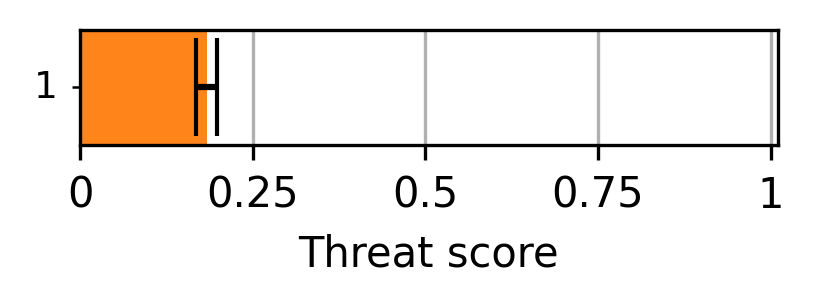

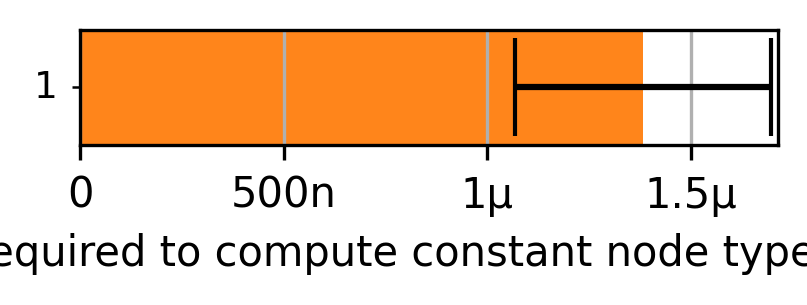

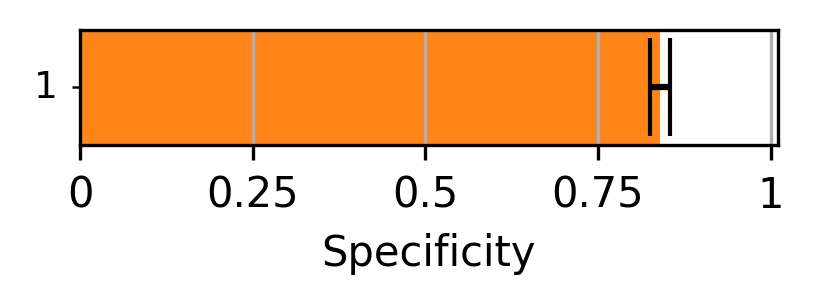

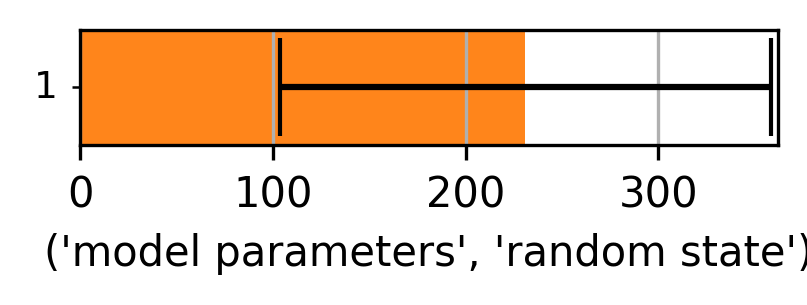

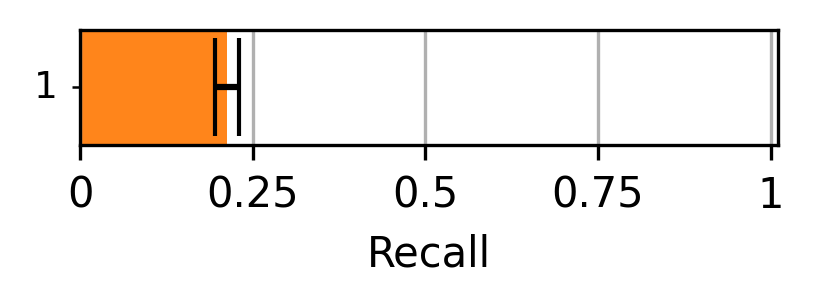

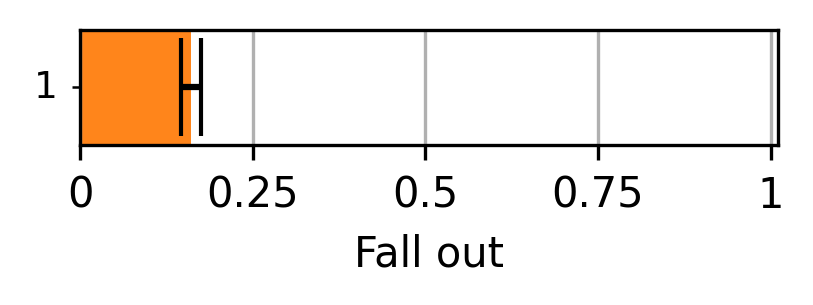

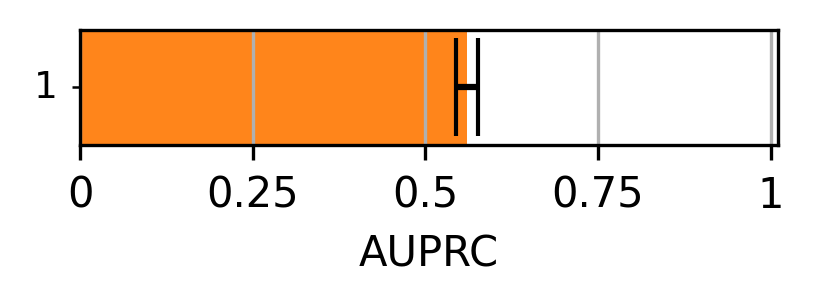

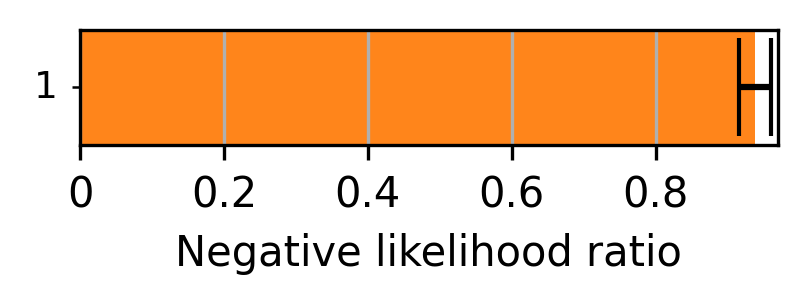

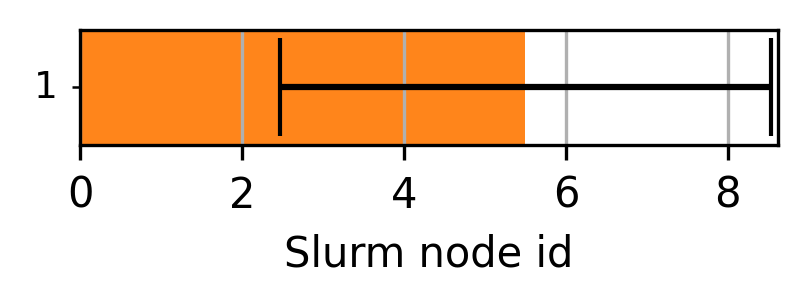

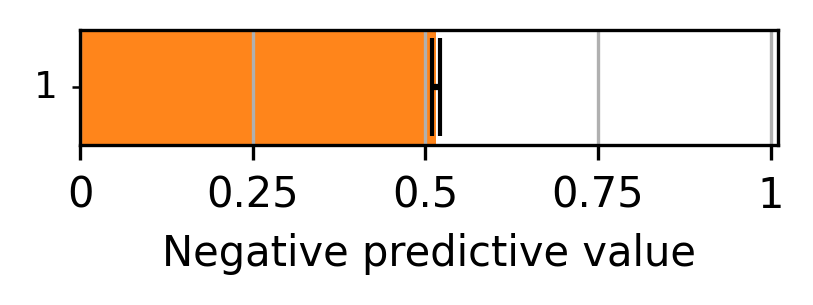

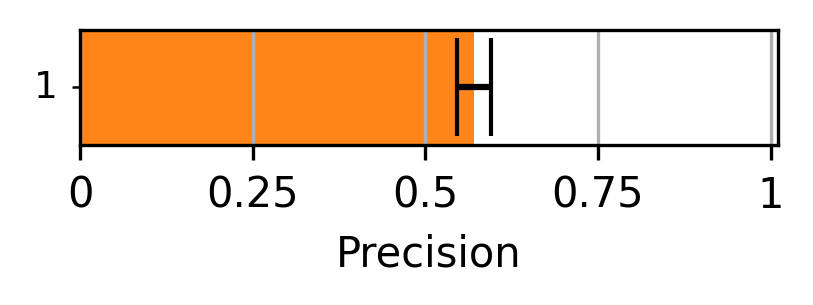

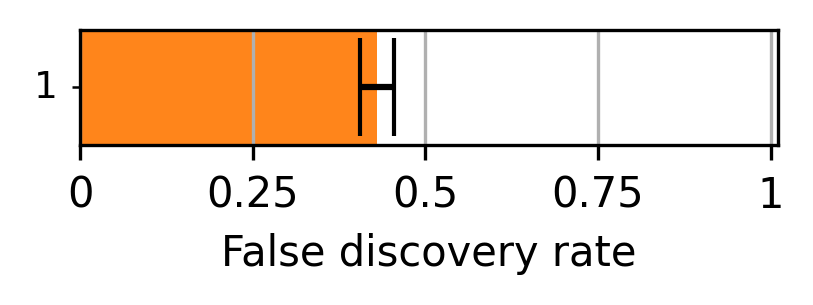

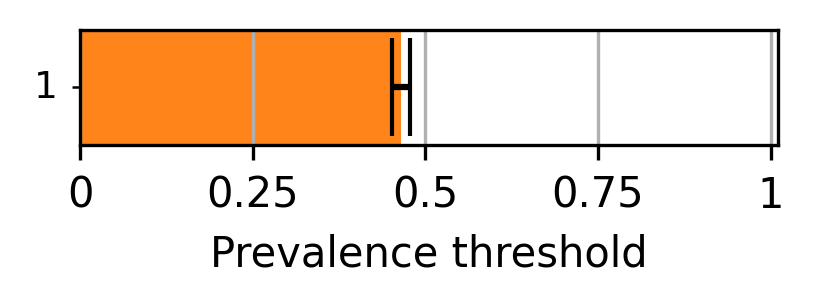

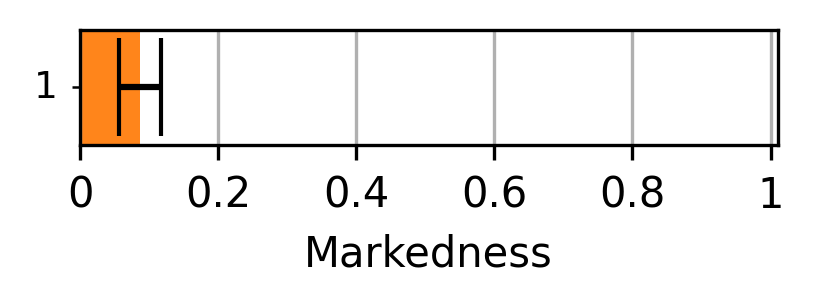

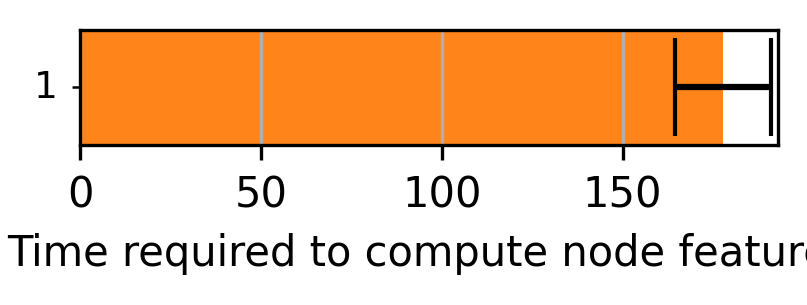

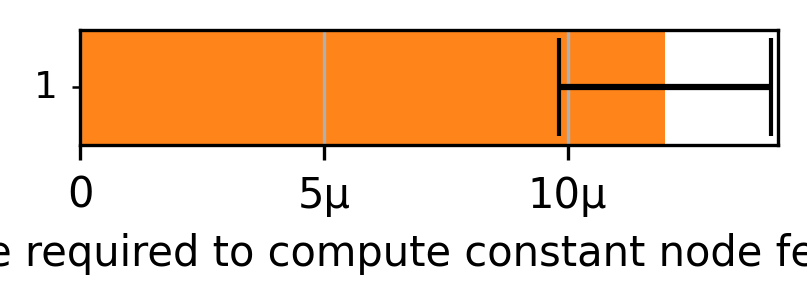

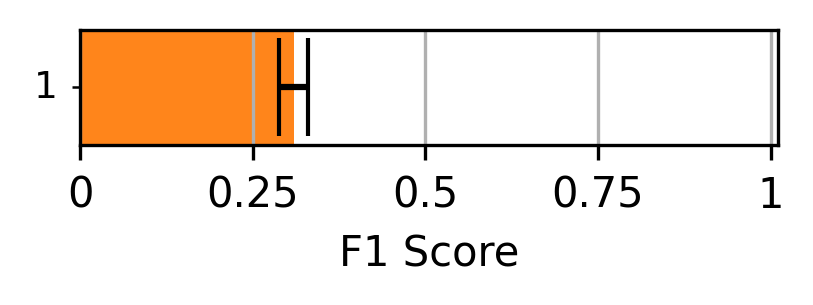

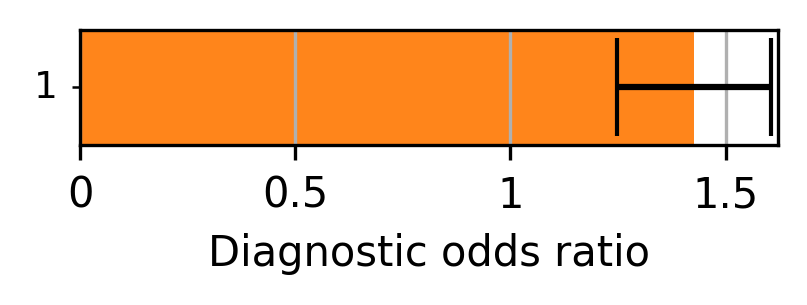

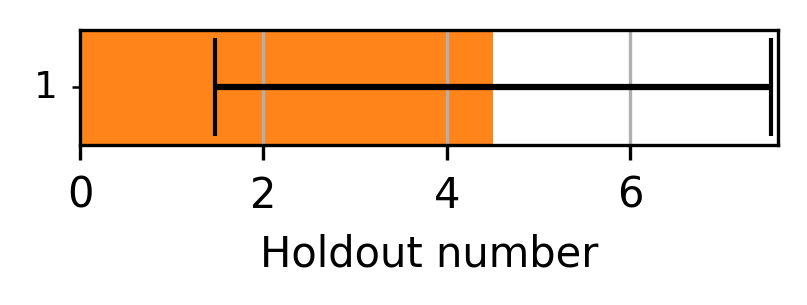

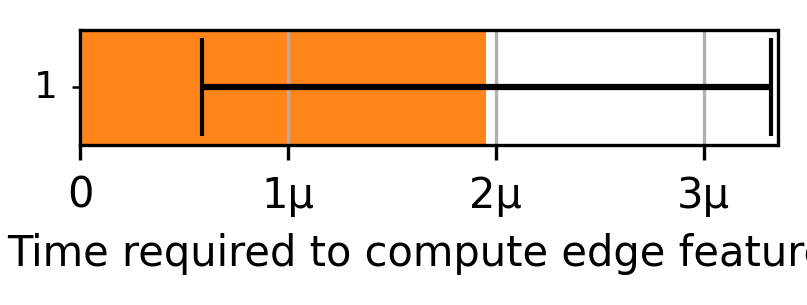

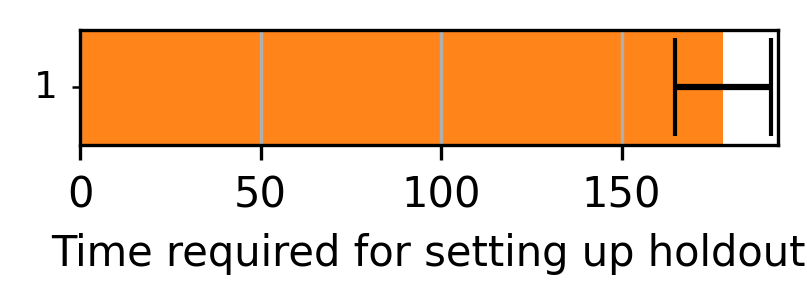

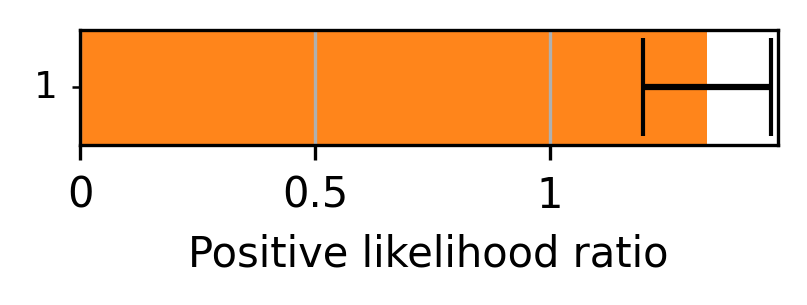

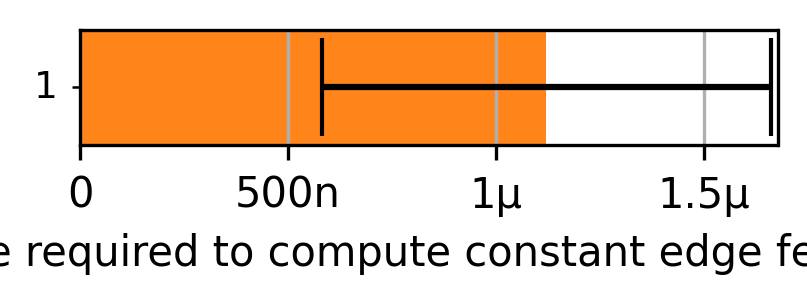

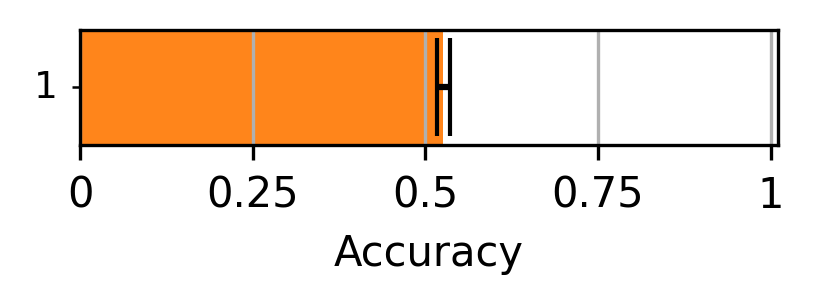

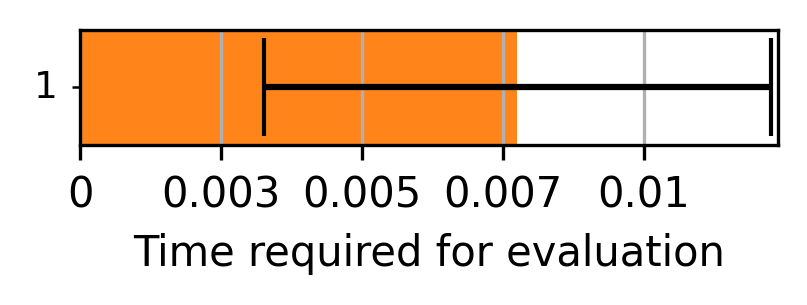

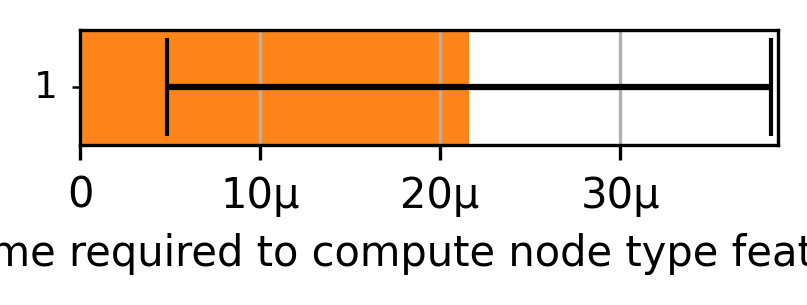

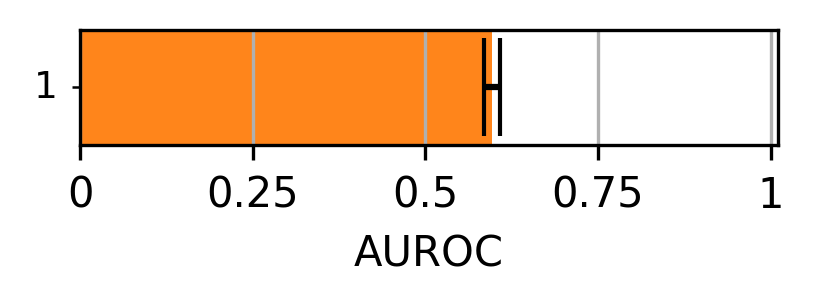

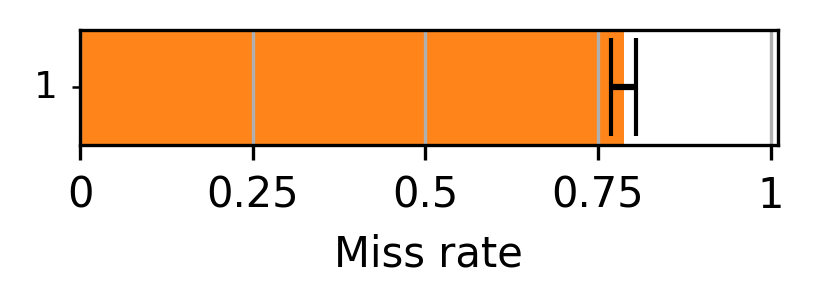

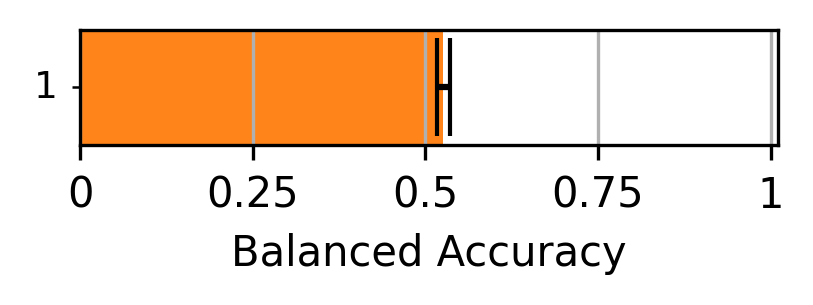

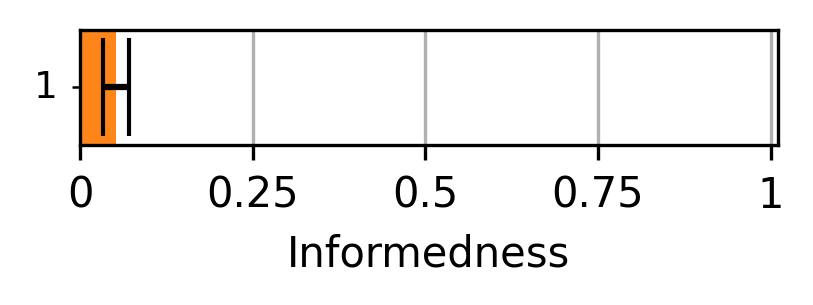

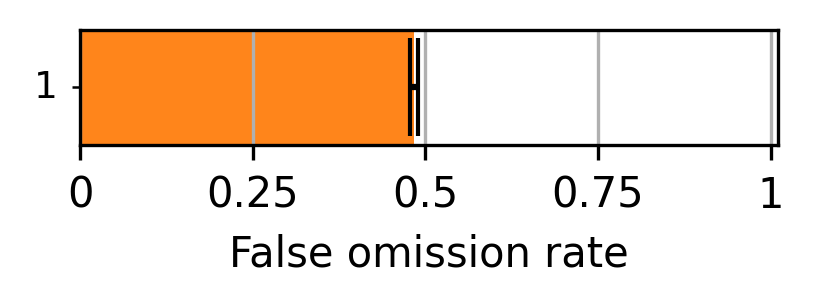

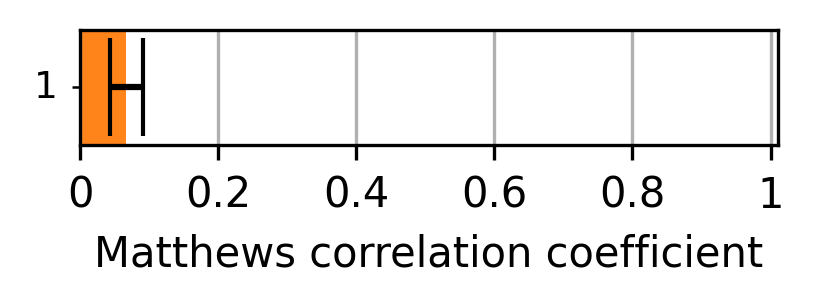

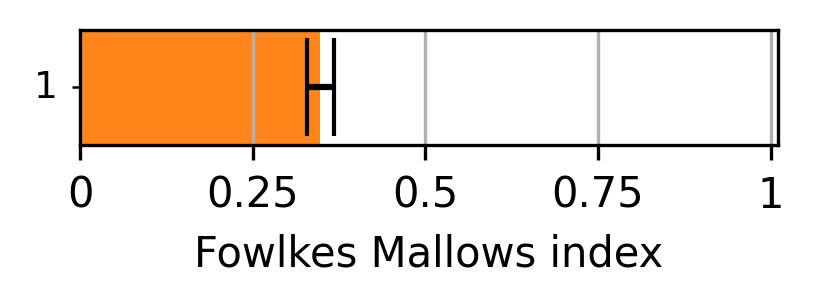

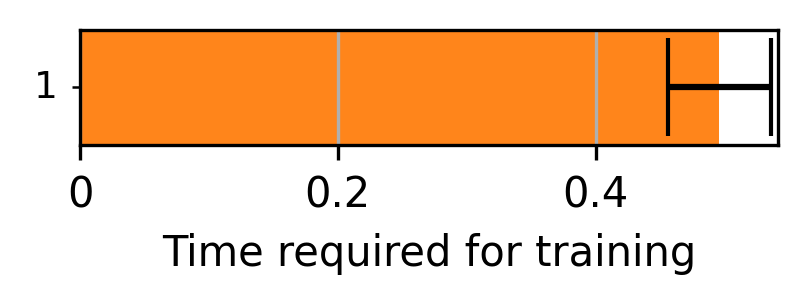

In [43]:
print_evaluation_as_single_pdf(df2, "DeepWalk GloVe Uniform train")

In [ ]:
df3 = df2[(df2["features_names"]=="DeepWalk GloVe Uniform train") & (df2['train_size'] == 0.75)]
df3 = df3.sort_values('validation_unbalance_rate',ascending=True)
df3.head()

In [ ]:
df3.dtypes

In [ ]:
groupby=[
    "features_names",
    "validation_unbalance_rate",
    "use_scale_free_distribution",
    "model_name"
    #"train_size",
]

color_dict = {'Biased':'tab:orange', 'Unbiased':'tab:blue'}

bplist = barplots(
    df3,
    groupby=groupby,
    path='barplots/{feature}.pdf',
    data_label="data-{feature}",
    show_legend=False,
    colors=color_dict,
    height=3,
    ncol=2,
    dpi=300,
    plots_per_row=2,
    subplots=True,
    bar_width=0.5,
    space_width=0.1,
    minor_rotation=0,
    major_rotation=0,
    unique_minor_labels=False,
    unique_major_labels=False,
    orientation="horizontal",
)

In [ ]:
def get_aggregate_stats(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df argument must be pandas data frame")
    columns = df.columns
    if not 'validation_unbalance_rate' in columns:
        raise ValueError("df must have column: validation_unbalance_rate")
    # calculate MEAN, STDDEV
    result = df3.groupby(["validation_unbalance_rate",  "use_scale_free_distribution","train_size"], 
                     as_index=False).agg(
                      {'balanced_accuracy':['mean','std'],
                       'f1_score':['mean','std'],
                      'auprc':['mean','std'],
                      'auroc':['mean','std']})
    return result


In [ ]:
results = get_aggregate_stats(df3)

In [ ]:
results.head()

In [ ]:
result = df3.groupby(["validation_unbalance_rate",  "use_scale_free_distribution","train_size"], 
                     as_index=False).agg(
                      {'balanced_accuracy':['mean','std'],
                       'f1_score':['mean','std'],
                      'auprc':['mean','std'],
                      'auroc':['mean','std']})

In [ ]:
ba = result[['validation_unbalance_rate','use_scale_free_distribution','train_size','balanced_accuracy']]
auprc = result[['validation_unbalance_rate','use_scale_free_distribution','train_size','auprc']]
auroc = result[['validation_unbalance_rate','use_scale_free_distribution','train_size','auroc']]
f1 = result[['validation_unbalance_rate','use_scale_free_distribution','train_size','f1_score']]

In [ ]:
# f1[['f1_score']].plot(kind='bar', yerr=df[['std']].values.T, alpha = 0.5,error_kw=dict(ecolor='k'))
# Do something here to get individual plot and store it as PDF
ba

In [ ]:
# Also do something to get 4 panels at a time and make a PDF for each of the methods so that we have one
# figure with 4 panels each for the online supplement.